# See temporal resolutiong of 5 and 7 combined

In [2]:
# import warnings
# warnings.filterwarnings("ignore")

import csv
import numpy as np
import pandas as pd
# import geopandas as gpd
from IPython.display import Image
# from shapely.geometry import Point, Polygon
from math import factorial
import scipy
import scipy.signal
import os, os.path

from datetime import date
import datetime
import time

from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.linear_model import LinearRegression
from patsy import cr

# from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sb

import sys

from pylab import rcParams


# to move files from one directory to another
import shutil

In [3]:
sys.path.append('/Users/hn/Documents/00_GitHub/Ag/remote_sensing/python/')
import remote_sensing_core as rc
import remote_sensing_plot_core as rcp


# Directories

In [4]:
data_dir = "/Users/hn/Documents/01_research_data/remote_sensing/LandSat_NASA/GEE_data/"

# Read the Data

In [5]:
Landsat5_Tier1 = pd.read_csv(data_dir + "Landsat5_Tier1_2005.csv", low_memory = False)
Landsat7_Tier1 = pd.read_csv(data_dir + "Landsat7_Tier1_2005.csv", low_memory = False)

# Drop NA Values

In [6]:
Landsat5_Tier1 = Landsat5_Tier1[Landsat5_Tier1['EVI'].notna()]
Landsat7_Tier1 = Landsat7_Tier1[Landsat7_Tier1['EVI'].notna()]

# Add which Landsat

In [7]:
Landsat5_Tier1["landsat"] = "Landsat-5"
Landsat7_Tier1["landsat"] = "Landsat-7"

# Add human-readable time

In [8]:
Landsat5_Tier1 = rc.add_human_start_time(Landsat5_Tier1)
Landsat7_Tier1 = rc.add_human_start_time(Landsat7_Tier1)

In [11]:
unique_IDs = list(Landsat5_Tier1.ID.unique())
unique_IDs

['108447_WSDA_SF_2017', '99423_WSDA_SF_2017', '107433_WSDA_SF_2017']

In [12]:
Landsat7_Tier1.head(2)

,ID,county,DataSrc,CropTyp,doy,EVI,Irrigtn,RtCrpTy,LstSrvD,Notes,system_start_time,landsat,human_system_start_time
0,108447_WSDA_SF_2017,Grant,wsda,"corn, field",217.0,0.647095,rill,Alfalfa Hay,2017/07/11,NaN,1.091731e+09,Landsat-7,2004-08-05
1,108447_WSDA_SF_2017,Grant,wsda,"corn, field",224.0,0.643966,rill,Alfalfa Hay,2017/07/11,NaN,1.092336e+09,Landsat-7,2004-08-12


In [13]:
Landsat5_Tier1.head(2)

,ID,county,DataSrc,CropTyp,doy,EVI,Irrigtn,RtCrpTy,LstSrvD,Notes,system_start_time,landsat,human_system_start_time
0,108447_WSDA_SF_2017,Grant,wsda,"corn, field",216.0,0.550770,rill,Alfalfa Hay,2017/07/11,NaN,1.091644e+09,Landsat-5,2004-08-04
1,108447_WSDA_SF_2017,Grant,wsda,"corn, field",225.0,0.653504,rill,Alfalfa Hay,2017/07/11,NaN,1.092422e+09,Landsat-5,2004-08-13


# Combine data

In [14]:
Landsat_5_and_7 = pd.concat([Landsat5_Tier1, Landsat7_Tier1])
Landsat_5_and_7.reset_index(drop=True, inplace=True)

# Separate Each Field

In [15]:
Landsat_5_and_7_F1 = Landsat_5_and_7[Landsat_5_and_7.ID == unique_IDs[0]].copy()

# sort the damn data
Landsat_5_and_7_F1.sort_values(by=['system_start_time'], inplace=True)

# reset the damn index
Landsat_5_and_7_F1.reset_index(drop=True, inplace=True)

In [16]:
Landsat_5_and_7_F2 = Landsat_5_and_7[Landsat_5_and_7.ID == unique_IDs[1]].copy()

Landsat_5_and_7_F2.sort_values(by=['system_start_time'], inplace=True)
Landsat_5_and_7_F2.reset_index(drop=True, inplace=True)

In [17]:
Landsat_5_and_7_F3 = Landsat_5_and_7[Landsat_5_and_7.ID == unique_IDs[2]].copy()

Landsat_5_and_7_F3.sort_values(by=['system_start_time'], inplace=True)
Landsat_5_and_7_F3.reset_index(drop=True, inplace=True)

In [18]:
Landsat_5_and_7_F1.head(2)

,ID,county,DataSrc,CropTyp,doy,EVI,Irrigtn,RtCrpTy,LstSrvD,Notes,system_start_time,landsat,human_system_start_time
0,108447_WSDA_SF_2017,Grant,wsda,"corn, field",216.0,0.550770,rill,Alfalfa Hay,2017/07/11,NaN,1.091644e+09,Landsat-5,2004-08-04
1,108447_WSDA_SF_2017,Grant,wsda,"corn, field",217.0,0.647095,rill,Alfalfa Hay,2017/07/11,NaN,1.091731e+09,Landsat-7,2004-08-05


In [19]:
rcParams['figure.figsize'] = 10, 12

title_FontSize = 15
legend_FontSize = 12
tick_FontSize = 18
label_FontSize = 22
#
#  Once set, you cannot change them, unless restart the notebook
#
plt.rc('font', family = 'georgia')
# plt.rc('text', usetex = True)
plt.rc('xtick', labelsize = 15)
plt.rc('ytick', labelsize = 15) # x-small


<Figure size 720x864 with 0 Axes>

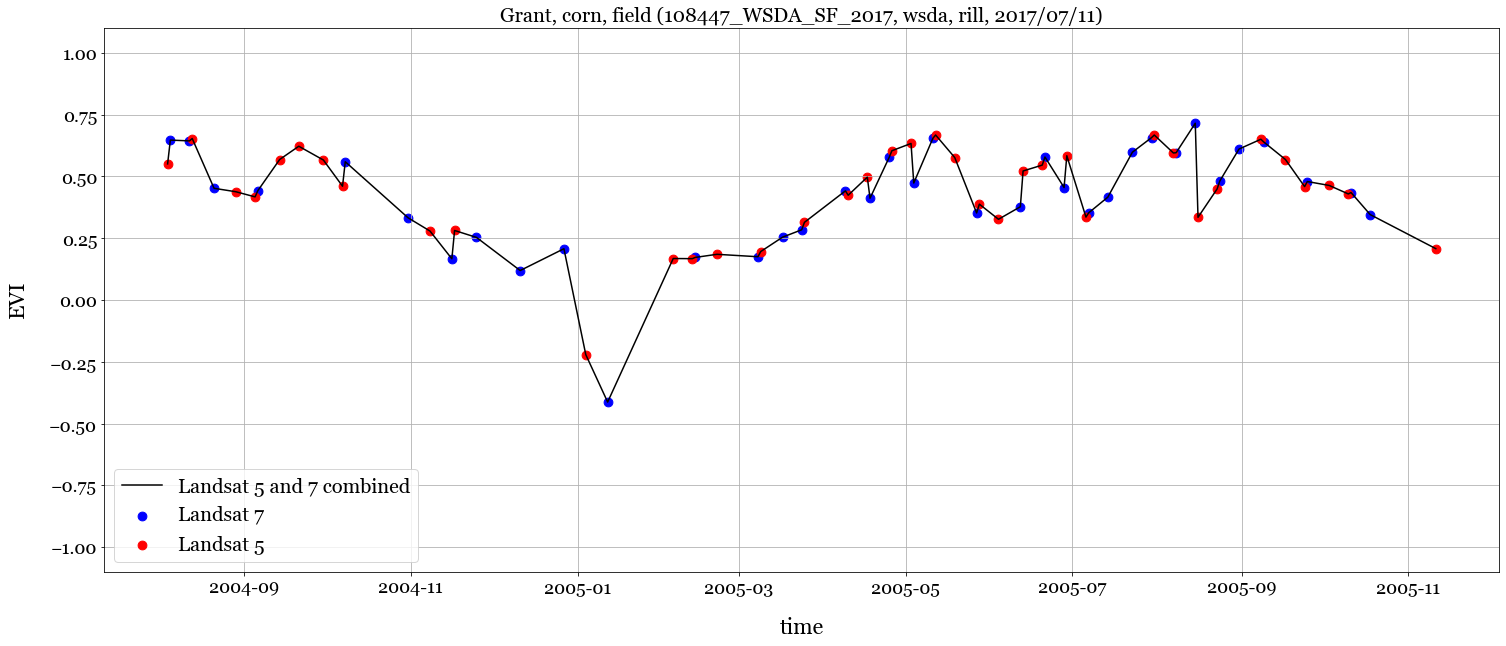

In [21]:
curr_data = Landsat_5_and_7_F1

curr_data_landsat5 = curr_data[curr_data.landsat == "Landsat-5"]
curr_data_landsat7 = curr_data[curr_data.landsat == "Landsat-7"]
curr_ID = curr_data.ID.unique()[0]


plt.figure()

fig, ax = plt.subplots()
fig.set_size_inches(25, 10)

################################################
#
# Plot the data
#
x = curr_data.human_system_start_time.values
y = curr_data.EVI.values
ax.plot(x, y, '-k', ls='-', label = 'Landsat 5 and 7 combined')


x = curr_data_landsat7.human_system_start_time.values
y = curr_data_landsat7.EVI.values
ax.scatter(x, y, c='b', s=77, label = 'Landsat 7')


x = curr_data_landsat5.human_system_start_time.values
y = curr_data_landsat5.EVI.values
ax.scatter(x, y, c='r', s=77, label = 'Landsat 5')


################################################
#
# Set labels and ticks
#
ax.set_xlabel('time', fontsize = label_FontSize, labelpad=20);
ax.set_ylabel('EVI', fontsize = label_FontSize, labelpad=20);
ax.tick_params(axis='y', which='major', labelsize = tick_FontSize)
ax.tick_params(axis='x', which='major', labelsize = tick_FontSize)
ax.legend(loc="lower left", fontsize=20);
ax.set_ylim([-1.1, 1.1])
# ax2.set_xlim([0, 2000])

################################################
#
#  show all xticks at data points
#
# plt.xticks(x)
# plt.gca().xaxis.set_major_locator(mdates.DateLocator())

# plt.gca().xaxis.set_major_locator(mtick.FixedLocator(x)) # Set tick locations
# plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x,p:getMonthName(x)))
# ax.set_xticklabels(ax.get_xticks(), rotation = 90)


a_title = curr_data.county.unique()[0] + ", " + \
          curr_data.CropTyp.unique()[0] + " (" + \
          curr_data.ID.unique()[0] +  ", " + \
          curr_data.DataSrc.unique()[0] +  ", " + \
          curr_data.Irrigtn.unique()[0] +  ", " + \
          curr_data.LstSrvD.unique()[0] +  ")"

ax.set_title(a_title, fontsize=20);
ax.grid(True)

file_name = data_dir + curr_ID + "_Lantsat5_7_separ.png"
plt.savefig(fname = file_name, dpi=600, bbox_inches='tight', transparent=False)
plt.show()


<Figure size 720x864 with 0 Axes>

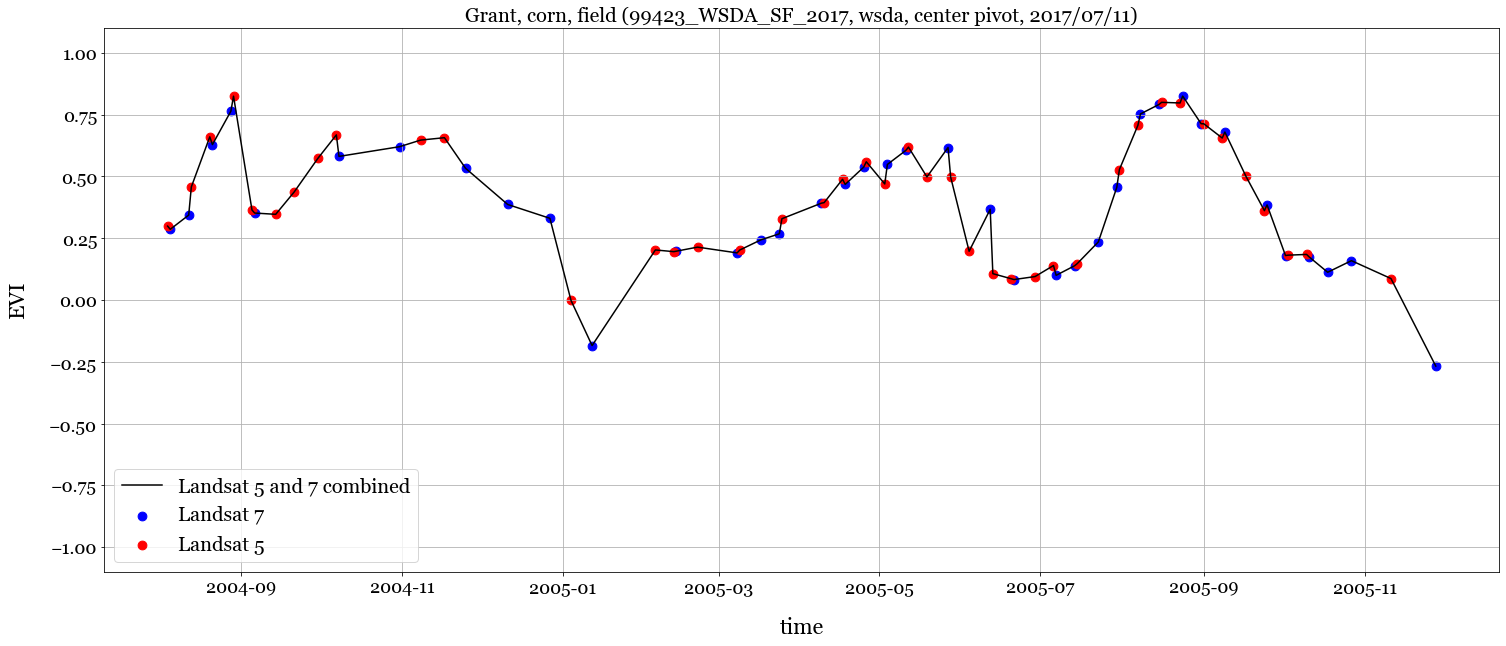

In [22]:
curr_data = Landsat_5_and_7_F2

curr_data_landsat5 = curr_data[curr_data.landsat == "Landsat-5"]
curr_data_landsat7 = curr_data[curr_data.landsat == "Landsat-7"]
curr_ID = curr_data.ID.unique()[0]


plt.figure()

fig, ax = plt.subplots()
fig.set_size_inches(25, 10)

################################################
#
# Plot the data
#
x = curr_data.human_system_start_time.values
y = curr_data.EVI.values
ax.plot(x, y, '-k', ls='-', label = 'Landsat 5 and 7 combined')


x = curr_data_landsat7.human_system_start_time.values
y = curr_data_landsat7.EVI.values
ax.scatter(x, y, c='b', s=77, label = 'Landsat 7')


x = curr_data_landsat5.human_system_start_time.values
y = curr_data_landsat5.EVI.values
ax.scatter(x, y, c='r', s=77, label = 'Landsat 5')


################################################
#
# Set labels and ticks
#
ax.set_xlabel('time', fontsize = label_FontSize, labelpad=20);
ax.set_ylabel('EVI', fontsize = label_FontSize, labelpad=20);
ax.tick_params(axis='y', which='major', labelsize = tick_FontSize)
ax.tick_params(axis='x', which='major', labelsize = tick_FontSize)
ax.legend(loc="lower left", fontsize=20);
ax.set_ylim([-1.1, 1.1])
# ax2.set_xlim([0, 2000])

################################################
#
#  show all xticks at data points
#
# plt.xticks(x)
# plt.gca().xaxis.set_major_locator(mdates.DateLocator())

# plt.gca().xaxis.set_major_locator(mtick.FixedLocator(x)) # Set tick locations
# plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x,p:getMonthName(x)))
# ax.set_xticklabels(ax.get_xticks(), rotation = 90)


a_title = curr_data.county.unique()[0] + ", " + \
          curr_data.CropTyp.unique()[0] + " (" + \
          curr_data.ID.unique()[0] +  ", " + \
          curr_data.DataSrc.unique()[0] +  ", " + \
          curr_data.Irrigtn.unique()[0] +  ", " + \
          curr_data.LstSrvD.unique()[0] +  ")"

ax.set_title(a_title, fontsize=20);
ax.grid(True)

file_name = data_dir + curr_ID + "_Lantsat5_7.png"
plt.savefig(fname = file_name, dpi=600, bbox_inches='tight', transparent=False)
plt.show()


<Figure size 720x864 with 0 Axes>

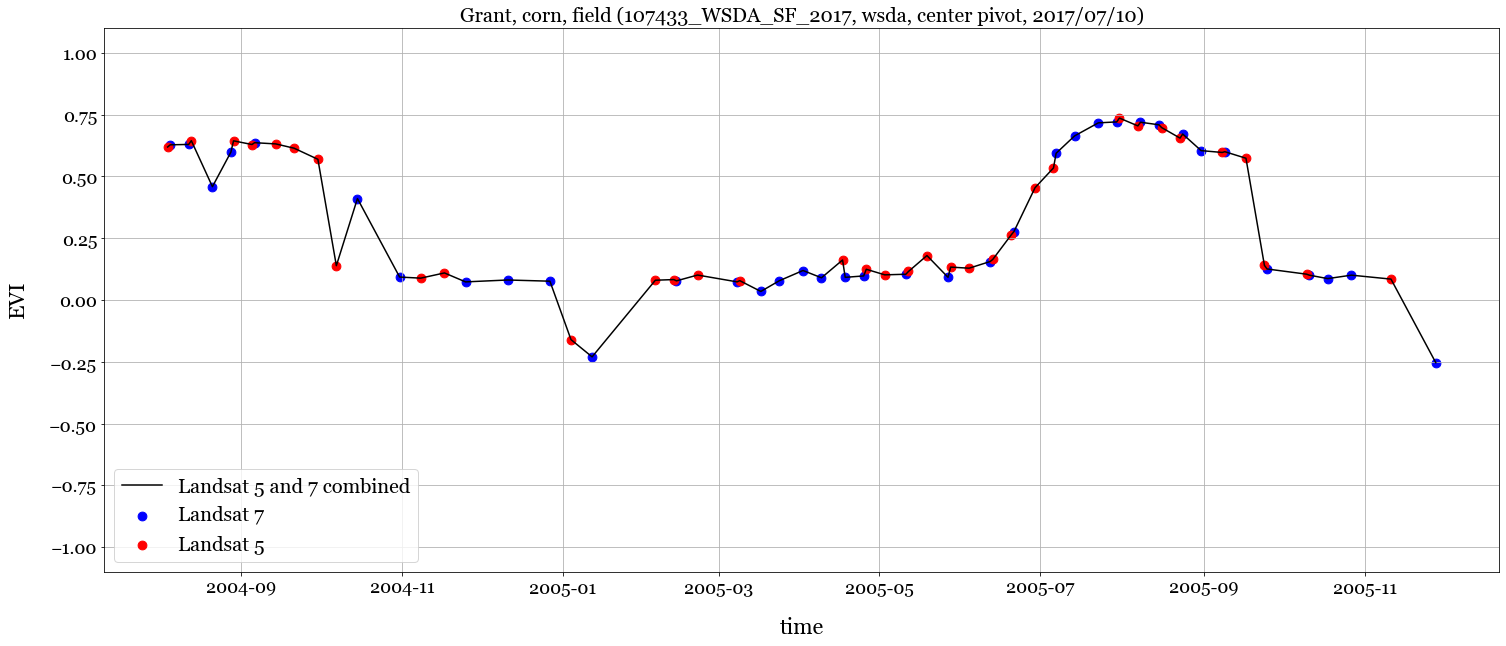

In [23]:
curr_data = Landsat_5_and_7_F3

curr_data_landsat5 = curr_data[curr_data.landsat == "Landsat-5"]
curr_data_landsat7 = curr_data[curr_data.landsat == "Landsat-7"]
curr_ID = curr_data.ID.unique()[0]


plt.figure()

fig, ax = plt.subplots()
fig.set_size_inches(25, 10)

################################################
#
# Plot the data
#
x = curr_data.human_system_start_time.values
y = curr_data.EVI.values
ax.plot(x, y, '-k', ls='-', label = 'Landsat 5 and 7 combined')


x = curr_data_landsat7.human_system_start_time.values
y = curr_data_landsat7.EVI.values
ax.scatter(x, y, c='b', s=77, label = 'Landsat 7')


x = curr_data_landsat5.human_system_start_time.values
y = curr_data_landsat5.EVI.values
ax.scatter(x, y, c='r', s=77, label = 'Landsat 5')


################################################
#
# Set labels and ticks
#
ax.set_xlabel('time', fontsize = label_FontSize, labelpad=20);
ax.set_ylabel('EVI', fontsize = label_FontSize, labelpad=20);
ax.tick_params(axis='y', which='major', labelsize = tick_FontSize)
ax.tick_params(axis='x', which='major', labelsize = tick_FontSize)
ax.legend(loc="lower left", fontsize=20);
ax.set_ylim([-1.1, 1.1])
# ax2.set_xlim([0, 2000])

################################################
#
#  show all xticks at data points
#
# plt.xticks(x)
# plt.gca().xaxis.set_major_locator(mdates.DateLocator())

# plt.gca().xaxis.set_major_locator(mtick.FixedLocator(x)) # Set tick locations
# plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x,p:getMonthName(x)))
# ax.set_xticklabels(ax.get_xticks(), rotation = 90)


a_title = curr_data.county.unique()[0] + ", " + \
          curr_data.CropTyp.unique()[0] + " (" + \
          curr_data.ID.unique()[0] +  ", " + \
          curr_data.DataSrc.unique()[0] +  ", " + \
          curr_data.Irrigtn.unique()[0] +  ", " + \
          curr_data.LstSrvD.unique()[0] +  ")"

ax.set_title(a_title, fontsize=20);
ax.grid(True)

file_name = data_dir + curr_ID + "_Lantsat5_7_separ.png"
plt.savefig(fname = file_name, dpi=600, bbox_inches='tight', transparent=False)
plt.show()
